In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from monai.metrics import DiceMetric, MeanIoU, SurfaceDiceMetric, SSIMMetric, GeneralizedDiceScore
from segment_anything.utils.transforms import ResizeLongestSide
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from monai.losses import GeneralizedDiceLoss, DiceLoss, GeneralizedDiceFocalLoss
from monai.metrics import DiceMetric, GeneralizedDiceScore
from LinearWarmupCosine import LinearWarmupCosineAnnealingLR

PyTorch version: 1.13.0
Torchvision version: 0.14.0
CUDA is available: True


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [3]:
image_folder = 'D:\Yuheng Li\Segment Anything\\CVC-ColonDB\\images'
mask_folder =  'D:\Yuheng Li\Segment Anything\\CVC-ColonDB\\masks'
save_folder = 'D:\Yuheng Li\Segment Anything\\CVC-ColonDB\\predict'
os.makedirs(save_folder, exist_ok = True)

image_path = []
mask_path = []

for root, dirs, files in os.walk(image_folder, topdown=False): #finds MRI files
    for name in files:
        if name.endswith(".png"):
            apath=os.path.join(root, name)
            image_path.append(apath)
            
for root, dirs, files in os.walk(mask_folder, topdown=False): #finds MRI files
    for name in files:
        if name.endswith(".png"):
            apath=os.path.join(root, name)
            mask_path.append(apath)
            
print(image_path[-1], mask_path[-1])

# with open('D:\Yuheng Li\Segment Anything\kvasir-seg\\kavsir_bboxes.json') as f:
#     labels = json.load(f)

X_train, X_test, y_train, y_test = train_test_split(image_path, mask_path, test_size=0.2, random_state=42)



D:\Yuheng Li\Segment Anything\CVC-ColonDB\images\99.png D:\Yuheng Li\Segment Anything\CVC-ColonDB\masks\99.png


In [4]:
print(X_train[-1], y_train[-1])

D:\Yuheng Li\Segment Anything\CVC-ColonDB\images\191.png D:\Yuheng Li\Segment Anything\CVC-ColonDB\masks\191.png


In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

# sam_checkpoint = "sam_vit_l_0b3195.pth"
# model_type = "vit_l"


device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

transform = ResizeLongestSide(sam.image_encoder.img_size)


In [6]:
def extract_bboxes(mask, num_instances):

    """Compute bounding boxes from masks.

    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

 

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].

    """

    boxes = np.zeros([num_instances, 4], dtype=np.int32)

    for i in range(num_instances):

        m = mask

        # Bounding box.

        horizontal_indicies = np.where(np.any(m, axis=0))[0]

#         print("np.any(m, axis=0)",np.any(m, axis=0))

#         print("p.where(np.any(m, axis=0))",np.where(np.any(m, axis=0)))

        vertical_indicies = np.where(np.any(m, axis=1))[0]

        if horizontal_indicies.shape[0]:

            x1, x2 = horizontal_indicies[[0, -1]]

            y1, y2 = vertical_indicies[[0, -1]]

            # x2 and y2 should not be part of the box. Increment by 1.

            x2 += 1

            y2 += 1

        else:

            # No mask for this instance. Might happen due to

            # resizing or cropping. Set bbox to zeros

            x1, x2, y1, y2 = 0, 0, 0, 0

        boxes[i] = np.array([y1, x1, y2, x2])

    return boxes.astype(np.int32)

In [10]:
# coco mask style dataloader

class ColonDataset(Dataset):
    def __init__(self, image_path, mask_path, image_size):
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_size = image_size
        
        # TODO: use ResizeLongestSide and pad to square
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        idx = self.image_path[index].split('images\\')[1].split('.png')[0]

        image = cv2.imread(self.image_path[index])
        gt = cv2.imread(self.mask_path[index])
        gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY) / 255
        gt = gt.astype('float32')

        bbox_arr = extract_bboxes(gt, 1)

        gt_resized = cv2.resize(gt, (1024, 1024), cv2.INTER_NEAREST)
        gt_resized = torch.as_tensor(gt_resized > 0).long()
        
        gt = torch.from_numpy(gt)
        gt_binary_mask = torch.as_tensor(gt > 0).long()

        transform = ResizeLongestSide(self.image_size)
        input_image = transform.apply_image(image)
        input_image =  cv2.resize(input_image, (1024, 1024), cv2.INTER_CUBIC)
        input_image= self.to_tensor(input_image)
        
        # input_image= self.normalize(input_image)
#         print(input_image.shape)
#         plt.figure()
#         plt.imshow(input_image[0])
#         print('before preprcoess', torch.max(input_image[0]), torch.min(input_image[0]))
        # input_image = sam.preprocess(input_image.to('cuda:0')).detach().cpu()
#         print('after preprcoess', torch.max(input_image[0]), torch.min(input_image[0]))
#         input_image = cv2.resize(input_image.numpy(), (1024, 1024), cv2.INTER_CUBIC)

#         plt.figure()
#         plt.imshow(input_image[0])
        
        original_image_size = image.shape[:2]
        input_size = tuple(input_image.shape[-2:])
        
        return input_image, np.array(bbox_arr), gt_binary_mask, gt_resized, original_image_size, input_size
    

def my_collate(batch):
    
    images, bboxes, masks, gt_resized, original_image_size, input_size = zip(*batch)
    images = torch.stack(images, dim=0)
    gt_resized = torch.stack(gt_resized, dim=0)
    
    masks = [m for m in masks]
    bboxes = [m for m in bboxes]
    original_image_size = [m for m in original_image_size]
    input_size = [m for m in input_size]
    
    return images, bboxes, masks, gt_resized, original_image_size, input_size

    

In [11]:

train_dataset = ColonDataset(X_train, y_train, sam.image_encoder.img_size)
train_dataloader = DataLoader(train_dataset, batch_size=42, shuffle=True, collate_fn = my_collate)

val_dataset = ColonDataset(X_test, y_test, sam.image_encoder.img_size)
val_dataloader = DataLoader(val_dataset, batch_size=42, shuffle=True, collate_fn = my_collate)


(500, 574) [[257 209 375 320]]
[[372.85017422 526.336      570.87108014 768.        ]]
torch.Size([42, 3, 1024, 1024])
tensor(1.) tensor(0.)
(1, 4)
torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
[[257 209 375 320]]


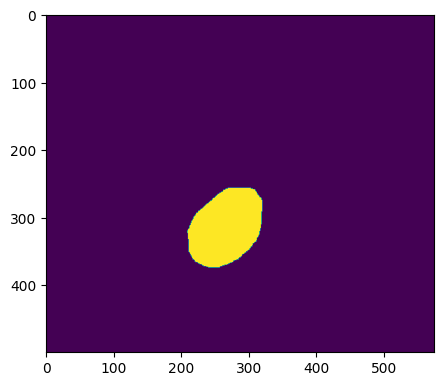

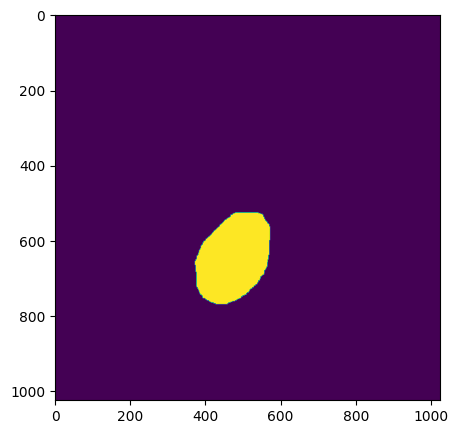

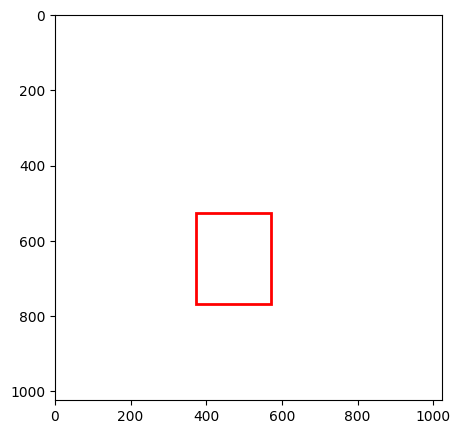

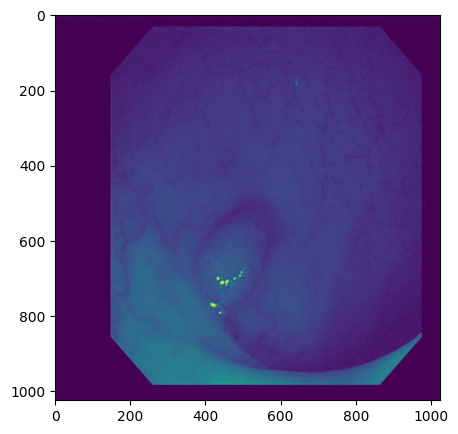

In [13]:
from matplotlib.patches import Rectangle

for batch in train_dataloader:

    img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

    for i in range(len(mask)):
        print(original_image_size[i], bbox[i])
        orig_x, orig_y =  original_image_size[i][0], original_image_size[i][1]
#         col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
#         col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
        col_x1, col_x2 = bbox[i][:,1] * 1024/orig_y, bbox[i][:,3]* 1024/orig_y
        col_y1, col_y2 = bbox[i][:,0]* 1024/orig_x, bbox[i][:,2]* 1024/orig_x
        
        box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()
        print(box)
        print(img.shape)
        img = img[0]
        gt_resized = gt_resized[0]
        print(img.max(), img.min())
        print(box.shape)
        print(img.shape, gt_resized.shape)
        plt.figure(figsize = (5,5))
        plt.imshow(mask[0])
        plt.figure(figsize = (5,5))
        plt.imshow(gt_resized)
        fig, ax = plt.subplots(figsize = (5,5))
        ax.set_xlim(0, 1024) 
        ax.set_ylim(0, 1024)
        plt.gca().invert_yaxis()
        rect = Rectangle((col_x1[0], col_y1[0]), col_x2[0]-col_x1[0], col_y2[0]-col_y1[0], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.figure(figsize = (5,5))
        plt.imshow(img[0])
        print(bbox[i])
        
        # show the plot
        plt.show()

        break
    break

In [14]:

num_epochs = 200
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 4e-6
wd = 1e-4
torch.backends.cudnn.benchmark = True
parameters = list(sam.mask_decoder.parameters()) + list(sam.image_encoder.parameters()) + list(sam.prompt_encoder.parameters())
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

from monai.losses import GeneralizedDiceLoss, DiceLoss, GeneralizedDiceFocalLoss

root_dir = 'D:\\Yuheng Li\\Segment Anything\\Model results\\CVC Colon\\SAM Finetune Enc Dec'

os.makedirs(root_dir, exist_ok = True)
# loss_fn = GeneralizedDiceLoss(to_onehot_y=False)
loss_fn = DiceLoss(to_onehot_y=False)


from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

losses = []
dice_score = []
gd_score = []
iou_score = []

best_dice = -1
best_gd = -1
best_score = -1
best_iou = -1

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in train_dataloader:

        img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

        batch_loss = 0
        
        for i in range(len(mask)):
            with torch.cuda.amp.autocast():

                image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))

                orig_x, orig_y =  original_image_size[i][0], original_image_size[i][1]
                col_x1, col_x2 = bbox[i][:,1] * 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                col_y1, col_y2 = bbox[i][:,0]* 1024/orig_x, bbox[i][:,2]* 1024/orig_x

                box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                  points=None,
                  boxes=box_torch,
                  masks=None,
                )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False,
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i]).to(device)

                binary_mask = torch.sigmoid(upscaled_masks)

                gt_binary_mask = mask[i].to(device)

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                loss = loss_fn(binary_mask[0], gt_binary_mask.unsqueeze(0)) / len(mask)
                scaler.scale(loss).backward()
                batch_loss += loss.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        epoch_losses.append(batch_loss / len(mask))
        optimizer.zero_grad()
    scheduler.step()
    losses.append(mean(epoch_losses))
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    
    
    with torch.no_grad():
        batch_dice = []
        batch_gd = []
        batch_iou = []

        for batch in val_dataloader:

            img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

            dice = DiceMetric()
            gd =  GeneralizedDiceScore()
            iou = MeanIoU()

            for i in range(len(mask)):
                image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))
                
                orig_x, orig_y =  original_image_size[i][0], original_image_size[i][1]
                col_x1, col_x2 = bbox[i][:,1] * 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                col_y1, col_y2 = bbox[i][:,0]* 1024/orig_x, bbox[i][:,2]* 1024/orig_x

                box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                num_masks = box.shape[0]
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                  points=None,
                  boxes= box_torch,
                  masks = None
                )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i])
                
                binary_mask = torch.sigmoid(upscaled_masks.detach().cpu())
                binary_mask =  (binary_mask>0.5).float()

                gt_binary_mask = mask[i].detach().cpu()

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                dice.reset()
                gd.reset()
                iou.reset()


                dice(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                gd(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                iou(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                final_dice = dice.aggregate().numpy()[0]
                final_gd = gd.aggregate().numpy()[0]
                final_iou = iou.aggregate().numpy()[0]
                batch_dice.append(final_dice)
                batch_gd.append(final_gd)
                batch_iou.append(final_iou)


        if (sum(batch_dice) / len(batch_dice)) > best_dice:
            best_dice = sum(batch_dice) / len(batch_dice)   
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "dec_best_dice_model_DL.pth"),
            )
            torch.save(
                sam.image_encoder.state_dict(),
                os.path.join(root_dir, "img_enc_best_dice_model_DL.pth"),
            )
            torch.save(
                sam.prompt_encoder.state_dict(),
                os.path.join(root_dir, "prompt_enc_best_dice_model_DL.pth"),
            )

            print("saved new best dice model")
        
        if (sum(batch_gd) / len(batch_gd)) > best_gd:
            best_gd = sum(batch_gd) / len(batch_gd)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "dec_best_GD_model_DL.pth"),
            )
            torch.save(
                sam.image_encoder.state_dict(),
                os.path.join(root_dir, "img_enc_best_GD_model_DL.pth"),
            )
            torch.save(
                sam.prompt_encoder.state_dict(),
                os.path.join(root_dir, "prompt_enc_best_GD_model_DL.pth"),
            )

            print("saved new best GD model")
            
        if (sum(batch_iou) / len(batch_iou)) > best_iou:
            best_iou = sum(batch_iou) / len(batch_iou)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "dec_best_GD_model_DL.pth"),
            )
            torch.save(
                sam.image_encoder.state_dict(),
                os.path.join(root_dir, "img_enc_best_GD_model_DL.pth"),
            )
            torch.save(
                sam.prompt_encoder.state_dict(),
                os.path.join(root_dir, "prompt_enc_best_GD_model_DL.pth"),
            )
            print("saved new best IOU model")

        dice_score.append(sum(batch_dice) / len(batch_dice))
        gd_score.append(sum(batch_gd) / len(batch_gd))
        iou_score.append(sum(batch_iou) / len(batch_iou))


    print(f'Mean val dice: {dice_score[-1]}')
    print(f'Mean val gd: {gd_score[-1]}')
    print(f'Mean val iou: {iou_score[-1]}')



EPOCH: 0
Mean loss: 0.025698763878400706
saved new best dice model
saved new best GD model
saved new best IOU model
Mean val dice: 0.8455953460407296
Mean val gd: 0.7227291412583374
Mean val iou: 0.7835515200276859
EPOCH: 1
Mean loss: 0.026086427766547005
saved new best dice model
saved new best GD model
saved new best IOU model
Mean val dice: 0.8636837908507962
Mean val gd: 0.7291205085777236
Mean val iou: 0.8034601247452787
EPOCH: 2
Mean loss: 0.025172966094327245
saved new best dice model
saved new best IOU model
Mean val dice: 0.8687129960959091
Mean val gd: 0.7289632086298967
Mean val iou: 0.8102359642323694
EPOCH: 3
Mean loss: 0.023968113724203294
saved new best dice model
saved new best IOU model
Mean val dice: 0.8746072578513505
Mean val gd: 0.7288563093599422
Mean val iou: 0.817629573768691
EPOCH: 4
Mean loss: 0.02564350589818787
saved new best dice model
saved new best IOU model
Mean val dice: 0.8814599565965565
Mean val gd: 0.7286427983291153
Mean val iou: 0.825549220347679


KeyboardInterrupt: 

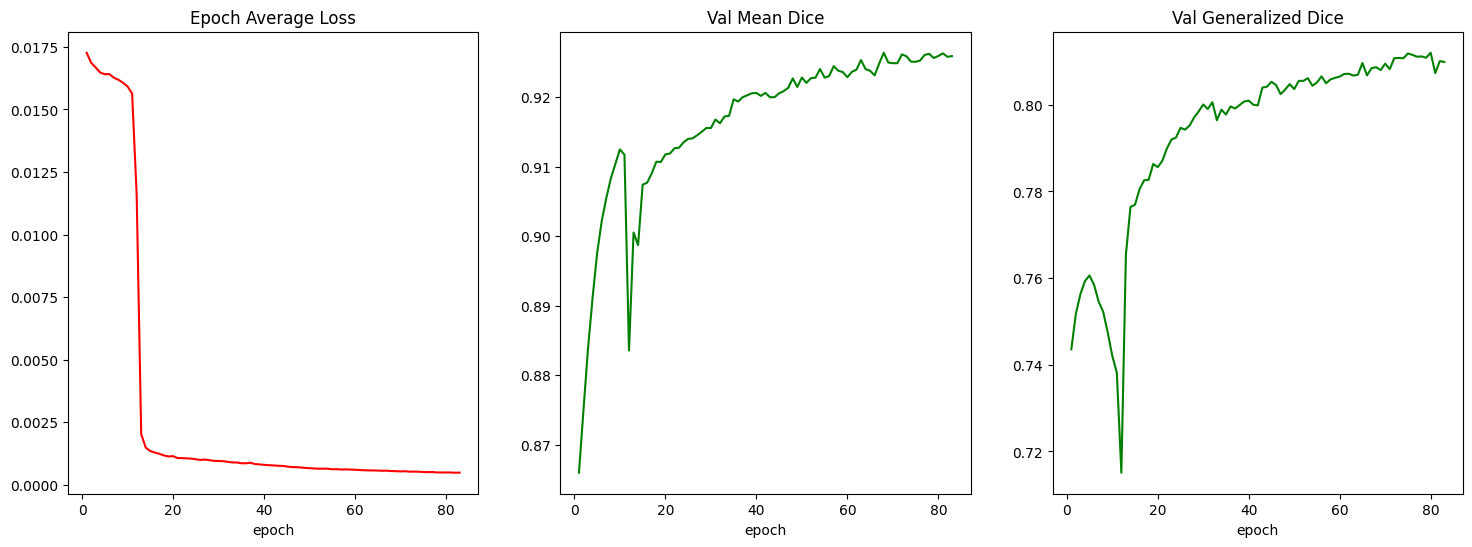

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


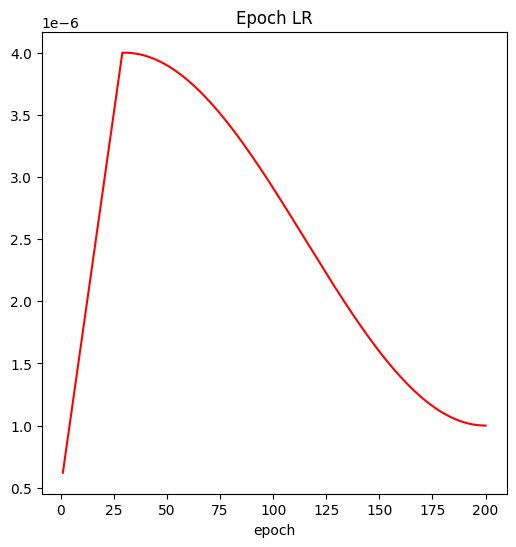

In [11]:
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(losses))]
y = losses
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
x = [(i + 1) for i in range(len(dice_score))]
y = dice_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.subplot(1, 3, 3)
plt.title("Val Generalized Dice")
x = [(i + 1) for i in range(len(gd_score))]
y = gd_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()



max_epochs = 200
optimizer = torch.optim.AdamW(parameters, lr=lr, weight_decay=wd)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

lr = []

for i in range(max_epochs):
    scheduler.step()  
    lr.append(optimizer.param_groups[0]['lr'])
    
plt.figure("train", (6, 6))
plt.title("Epoch LR")
x = [i + 1 for i in range(max_epochs)]
y = lr
plt.xlabel("epoch")
plt.plot(x, y, color="red")



In [16]:

# model_path =  'D:\\Yuheng Li\\Segment Anything\\Model results\\CVC Clinical\\SAM Finetune Enc Dec'

model_path  = 'D:\\Yuheng Li\\Segment Anything\\Model results\\SAM Finetune Enc Dec'

sam.prompt_encoder.load_state_dict(torch.load(os.path.join(model_path, "prompt_enc_best_dice_model_DL.pth")))
sam.image_encoder.load_state_dict(torch.load(os.path.join(model_path, "img_enc_best_dice_model_DL.pth")))
sam.mask_decoder.load_state_dict(torch.load(os.path.join(model_path, "dec_best_dice_model_DL.pth")))
sam.eval()

with torch.no_grad():
    batch_dice = []
    batch_gd = []
    batch_iou = []

    for batch in val_dataloader:

        img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

        dice = DiceMetric()
        gd =  GeneralizedDiceScore()
        iou = MeanIoU()

        for i in range(len(mask)):
            image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))

            orig_x, orig_y =  original_image_size[i][0], original_image_size[i][1]
            col_x1, col_x2 = bbox[i][:,1] * 1024/orig_y, bbox[i][:,3]* 1024/orig_y
            col_y1, col_y2 = bbox[i][:,0]* 1024/orig_x, bbox[i][:,2]* 1024/orig_x

            box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

            num_masks = box.shape[0]
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
              points=None,
              boxes= box_torch,
              masks = None
            )

            low_res_masks, iou_predictions = sam.mask_decoder(
              image_embeddings=image_embedding,
              image_pe=sam.prompt_encoder.get_dense_pe(),
              sparse_prompt_embeddings=sparse_embeddings,
              dense_prompt_embeddings=dense_embeddings,
              multimask_output=False
            )

            upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i])

            binary_mask = torch.sigmoid(upscaled_masks.detach().cpu())
            binary_mask =  (binary_mask>0.5).float()

            gt_binary_mask = mask[i].detach().cpu()

            if binary_mask.size()[0] > 1:
                binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

            dice.reset()
            gd.reset()
            iou.reset()

            dice(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
            gd(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
            iou(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
            final_dice = dice.aggregate().numpy()[0]
            final_gd = gd.aggregate().numpy()[0]
            final_iou = iou.aggregate().numpy()[0]
            batch_dice.append(final_dice)
            batch_gd.append(final_gd)
            batch_iou.append(final_iou)


    print(f'Mean val dice: {sum(batch_dice) / len(batch_dice)}')
    print(f'Mean val gd: {sum(batch_gd) / len(batch_gd)}')
    print(f'Mean val iou: {sum(batch_iou) / len(batch_iou)}')


Mean val dice: 0.9064574861212781
Mean val gd: 0.728120691780197
Mean val iou: 0.8546225169771596


In [7]:
from monai.losses import GeneralizedDiceLoss, DiceLoss, GeneralizedDiceFocalLoss

# root_dir = 'D:\\Yuheng Li\\Segment Anything\\Model results\\SAM Finetune Dec'
root_dir = 'D:\\Yuheng Li\\Segment Anything\\Model results\\SAM Finetune Dec\\vit_h' 

os.makedirs(root_dir, exist_ok = True)

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 4e-6
wd = 1e-4

num_epochs = 200

torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()

optimizer = torch.optim.AdamW(sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)

scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

# Freeze something

for param in sam.prompt_encoder.parameters():
    param.requires_grad = False
    
for param in sam.image_encoder.parameters():
    param.requires_grad = False

# loss_fn = GeneralizedDiceLoss(to_onehot_y=False)
loss_fn = DiceLoss(to_onehot_y=False)


from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

losses = []
dice_score = []
gd_score = []

best_dice = -1
best_score = -1
best_gd = -1

for epoch in range(num_epochs):
    
    epoch_losses = []

    for batch in train_dataloader:

        img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

        batch_loss = 0
        
        for i in range(len(mask)):
            with torch.cuda.amp.autocast():

                with torch.no_grad():

                    image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))

                    orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
                    col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
                    col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                    box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

                    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                      points=None,
                      boxes=box_torch,
                      masks=None,
                    )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False,
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i]).to(device)

                binary_mask = torch.sigmoid(upscaled_masks)

                gt_binary_mask = mask[i].to(device)

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                loss = loss_fn(binary_mask[0], gt_binary_mask.unsqueeze(0)) / len(mask)
                scaler.scale(loss).backward()
                batch_loss += loss.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        scaler.step(optimizer)
        scaler.update()
        epoch_losses.append(batch_loss / len(mask))
        optimizer.zero_grad()
        
    scheduler.step()
    losses.append(mean(epoch_losses))
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    
    
    with torch.no_grad():
        batch_dice = []
        batch_gd = []

        for batch in val_dataloader:

            img, bbox, mask, gt_resized, original_image_size, input_size = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

            dice = DiceMetric()
            gd =  GeneralizedDiceScore()

            for i in range(len(mask)):
                image_embedding = sam.image_encoder(img[i].unsqueeze(0).to(device))
                orig_x, orig_y =  original_image_size[i][1], original_image_size[i][0]
                col_x1, col_x2 = bbox[i][:,0] * 1024/orig_x, bbox[i][:,2]* 1024/orig_x
                col_y1, col_y2 = bbox[i][:,1]* 1024/orig_y, bbox[i][:,3]* 1024/orig_y
                box = np.array([col_x1, col_y1, col_x2, col_y2]).transpose()

                num_masks = box.shape[0]
                box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
                sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                  points=None,
                  boxes= box_torch,
                  masks = None
                )

                low_res_masks, iou_predictions = sam.mask_decoder(
                  image_embeddings=image_embedding,
                  image_pe=sam.prompt_encoder.get_dense_pe(),
                  sparse_prompt_embeddings=sparse_embeddings,
                  dense_prompt_embeddings=dense_embeddings,
                  multimask_output=False
                )

                upscaled_masks = sam.postprocess_masks(low_res_masks, input_size[i], original_image_size[i])
                
                binary_mask = torch.sigmoid(upscaled_masks.detach().cpu())
                binary_mask =  (binary_mask>0.5).float()

                gt_binary_mask = mask[i].detach().cpu()

                if binary_mask.size()[0] > 1:
                    binary_mask = torch.unsqueeze(torch.sum(binary_mask, 0) / binary_mask.size()[0],0)

                dice.reset()
                gd.reset()

                dice(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                gd(binary_mask[0,:], gt_binary_mask.unsqueeze(0))
                final_dice = dice.aggregate().numpy()[0]
                final_gd = gd.aggregate().numpy()[0]
                batch_dice.append(final_dice)
                batch_gd.append(final_gd)

        if (sum(batch_dice) / len(batch_dice)) > best_dice:
            best_dice = sum(batch_dice) / len(batch_dice)   
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "best_dice_model_DL.pth"),
            )
            print("saved new best dice model")
        
        if (sum(batch_gd) / len(batch_gd)) > best_gd:
            best_gd = sum(batch_gd) / len(batch_gd)
            torch.save(
                sam.mask_decoder.state_dict(),
                os.path.join(root_dir, "best_GD_model_DL.pth"),
            )
            print("saved new best GD model")

        dice_score.append(sum(batch_dice) / len(batch_dice))
        gd_score.append(sum(batch_gd) / len(batch_gd))

    print(f'Mean val dice: {dice_score[-1]}')
    print(f'Mean val gd: {gd_score[-1]}')



EPOCH: 0
Mean loss: 0.020940342272349102


y_pred should be a binarized tensor.


saved new best dice model
saved new best GD model
Mean val dice: 0.8296684896945954
Mean val gd: 0.515958188570512
EPOCH: 1
Mean loss: 0.021893451863572756
saved new best dice model
saved new best GD model
Mean val dice: 0.8297710946202278
Mean val gd: 0.5166318740096176
EPOCH: 2
Mean loss: 0.02782596077027154
saved new best GD model
Mean val dice: 0.82974280834198
Mean val gd: 0.5174484536414092
EPOCH: 3
Mean loss: 0.022078725193222497
saved new best GD model
Mean val dice: 0.8294496807456017
Mean val gd: 0.518601426150708
EPOCH: 4
Mean loss: 0.020456663417211356
saved new best GD model
Mean val dice: 0.828973067253828
Mean val gd: 0.520012712210737
EPOCH: 5
Mean loss: 0.011968072730676448
saved new best GD model
Mean val dice: 0.8282064601778985
Mean val gd: 0.5227986138587585
EPOCH: 6
Mean loss: 0.011753619638260543
saved new best GD model
Mean val dice: 0.8272535321116448
Mean val gd: 0.5253102199872955
EPOCH: 7
Mean loss: 0.008582778771787638
saved new best GD model
Mean val dice:

EPOCH: 59
Mean loss: 0.0038099573788626696
saved new best dice model
Mean val dice: 0.8696638384461403
Mean val gd: 0.5566280529888172
EPOCH: 60
Mean loss: 0.002773796308957528
saved new best dice model
Mean val dice: 0.8697311155498028
Mean val gd: 0.5570576869076467
EPOCH: 61
Mean loss: 0.006021454491599884
saved new best dice model
Mean val dice: 0.8701708289980888
Mean val gd: 0.5554045638396928
EPOCH: 62
Mean loss: 0.0024245680774107486
saved new best dice model
Mean val dice: 0.8703235438466073
Mean val gd: 0.5556429637791007
EPOCH: 63
Mean loss: 0.0037946832368366554
saved new best dice model
Mean val dice: 0.8704431781172752
Mean val gd: 0.555928908566566
EPOCH: 64
Mean loss: 0.0026728201192911783
saved new best dice model
Mean val dice: 0.8708291739225388
Mean val gd: 0.5541242127511942
EPOCH: 65
Mean loss: 0.006455886648334508
saved new best dice model
Mean val dice: 0.8709202435612678
Mean val gd: 0.5553161582328903
EPOCH: 66
Mean loss: 0.0036792280563704913
saved new best d

EPOCH: 122
Mean loss: 0.0047458511064524785
saved new best dice model
Mean val dice: 0.875615124553442
Mean val gd: 0.5458316215447848
EPOCH: 123
Mean loss: 0.002990854503773984
saved new best dice model
Mean val dice: 0.8756851245462894
Mean val gd: 0.5456096199236344
EPOCH: 124
Mean loss: 0.002537293227214832
saved new best dice model
Mean val dice: 0.8757002945244312
Mean val gd: 0.5454240988005767
EPOCH: 125
Mean loss: 0.002392363961137432
saved new best dice model
Mean val dice: 0.8757031746208668
Mean val gd: 0.5457606126050814
EPOCH: 126
Mean loss: 0.002282438054542235
saved new best dice model
Mean val dice: 0.8757776089012623
Mean val gd: 0.5458192857090034
EPOCH: 127
Mean loss: 0.0022472349740426233
saved new best dice model
Mean val dice: 0.8758178639411927
Mean val gd: 0.5457540199092182
EPOCH: 128
Mean loss: 0.0025208345877694056
Mean val dice: 0.8757916617393494
Mean val gd: 0.5460942543286365
EPOCH: 129
Mean loss: 0.0024405666716726653
Mean val dice: 0.8757993964850903
M

EPOCH: 186
Mean loss: 0.0027358427598907537
saved new best dice model
Mean val dice: 0.8774942091107368
Mean val gd: 0.5429787095241773
EPOCH: 187
Mean loss: 0.00218500873745056
Mean val dice: 0.8774516160786152
Mean val gd: 0.5435674978308088
EPOCH: 188
Mean loss: 0.002407327472246834
saved new best dice model
Mean val dice: 0.8775260181725025
Mean val gd: 0.5428928511792037
EPOCH: 189
Mean loss: 0.0041455974903545295
Mean val dice: 0.8775217689573764
Mean val gd: 0.5430063397019694
EPOCH: 190
Mean loss: 0.00234664051829549
saved new best dice model
Mean val dice: 0.8775389491021633
Mean val gd: 0.542958768116805
EPOCH: 191
Mean loss: 0.003309621716176653
Mean val dice: 0.8775291660428047
Mean val gd: 0.5432423885108437
EPOCH: 192
Mean loss: 0.002189108223423578
saved new best dice model
Mean val dice: 0.8776226440072059
Mean val gd: 0.5427224797944654
EPOCH: 193
Mean loss: 0.005134450820887217
Mean val dice: 0.8775914745032787
Mean val gd: 0.5429573864322447
EPOCH: 194
Mean loss: 0.0

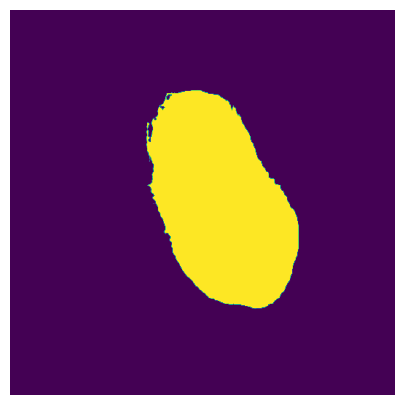

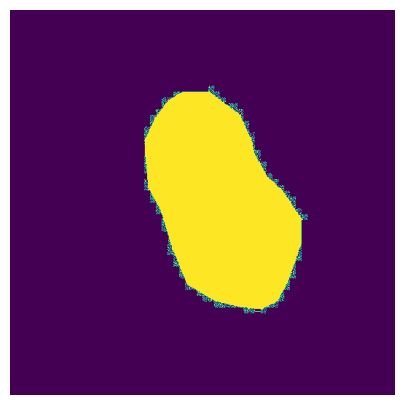

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(binary_mask.detach().cpu().numpy()[0,0])
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(gt_binary_mask.detach().cpu().numpy())
plt.axis('off')
plt.show()


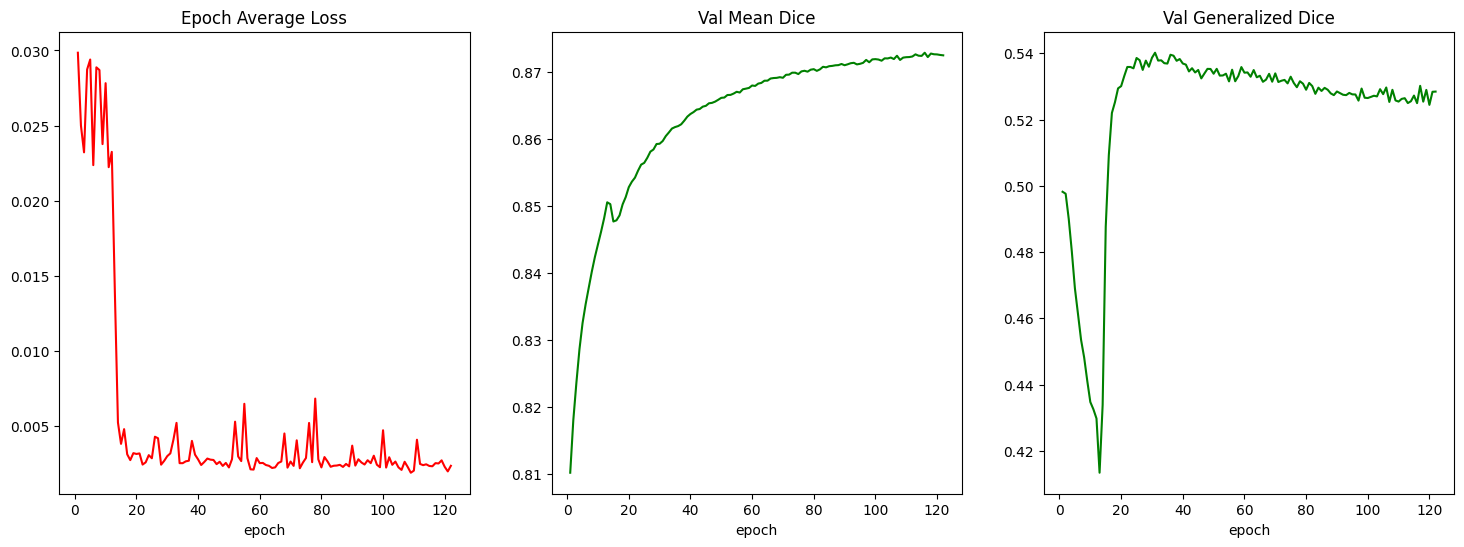

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


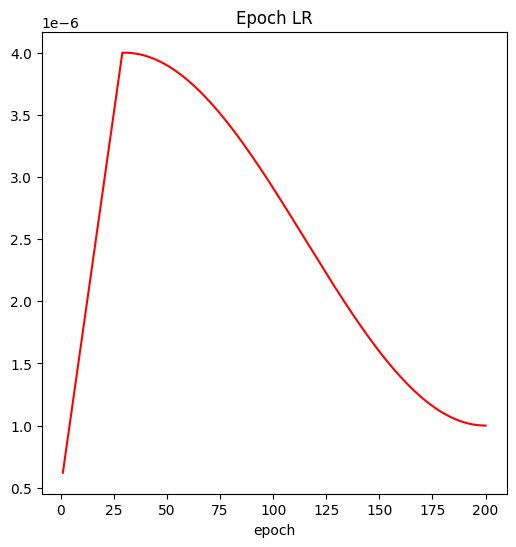

In [9]:
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(losses))]
y = losses
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
x = [(i + 1) for i in range(len(dice_score))]
y = dice_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.subplot(1, 3, 3)
plt.title("Val Generalized Dice")
x = [(i + 1) for i in range(len(gd_score))]
y = gd_score
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

max_epochs = 200
optimizer = torch.optim.AdamW(sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=30, max_epochs=num_epochs, warmup_start_lr=5e-7, eta_min = 1e-6)

lr = []

for i in range(max_epochs):
    scheduler.step()  
    lr.append(optimizer.param_groups[0]['lr'])
    
plt.figure("train", (6, 6))
plt.title("Epoch LR")
x = [i + 1 for i in range(max_epochs)]
y = lr
plt.xlabel("epoch")
plt.plot(x, y, color="red")



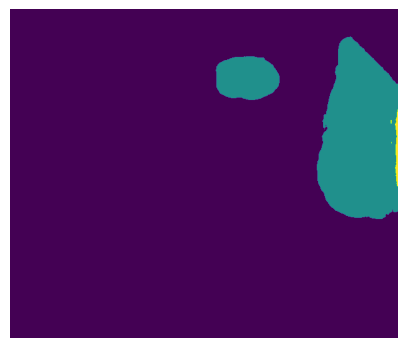

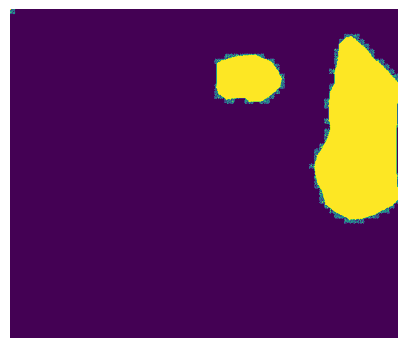

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.6666667


In [21]:
plt.figure(figsize=(5,5))
plt.imshow(binary_mask.detach().cpu().numpy()[0,0])
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(gt_binary_mask.detach().cpu().numpy())
plt.axis('off')

plt.show()
print(binary_mask.detach().cpu().numpy()[0,0])

print(np.max(binary_mask.detach().cpu().numpy()[0,0]))


In [ ]:

transformed_data = defaultdict(dict)

for i in range(0, 3):

    idx = image_path[i].split('images\\')[1].split('.jpg')[0]
    bbox = labels[idx]['bbox']

    bbox_arr = []
    x = [i['xmin'] for i in labels[idx]['bbox']]
    y = [i['ymin']for i in labels[idx]['bbox']]
    xx = [i['xmax'] for i in labels[idx]['bbox']]
    yy = [i['ymax'] for i in labels[idx]['bbox']]

    for k in range(len(bbox)):

        bbox_arr.append(np.array([x[k], y[k], xx[k], yy[k]]))

    bbox_arr = np.array(bbox_arr)

    image = cv2.imread(image_path[i])
    gt = cv2.imread(mask_path[i])
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY) / 255
    gt = gt.astype('float32')

    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image = transform.apply_image(image)
    print(input_image.shape)

    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    print(transformed_image.shape)

    input_image = sam.preprocess(transformed_image)
    print(input_image.shape)
    
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[i]['image'] = input_image
    transformed_data[i]['input_size'] = input_size
    transformed_data[i]['original_image_size'] = original_image_size
    transformed_data[i]['bbox_arr'] = bbox_arr
